# Manipulate  feature of each layer and observe the effect

In [1]:
import os
from typing import List, DefaultDict
from collections import defaultdict
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# from numpy.linalg import norm
# import matplotlib
from matplotlib import pyplot as plt
from clearn.experiments.experiment import Experiment


import tensorflow as tf
from clearn.utils.data_loader import TrainValDataIterator
from clearn.utils.data_loader import load_images
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
from clearn.analysis.encode_decode import decode, encode, encode_and_get_features, decode_and_get_features, decode_l3
from clearn.analysis.cluster_utils import plot_features, trace_dim
from matplotlib import pyplot  as  plt

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

# Function Definitions

In [2]:
def find_absolute_largest_weights(weights, num_out_units):
    """
    Find the maximum of absolute value weights connecting to each output unit
    @return returns an array of shape (num_out_units)
    """
    max_abs_for_each_out_dimension_weight = np.asarray([np.max(np.abs(weights[:, i])) for i in range(num_out_units)] )
    max_abs_for_each_out_dimension_weight = np.reshape(max_abs_for_each_out_dimension_weight, (num_out_units,1))
    return max_abs_for_each_out_dimension_weight


In [10]:
def get_significant_dimensions(lv_dimensions, file_name):
    """
    Find the indices with most significant values on the vector `lv_dimensions`
    @param lv_dimensions
    @param file_name full path and name of the file for saving the elbow graph
    @returns a 1-d ndarray with values as indices of most significant values in input vector
    """
    plt.figure()
    kmeans_model = KMeans()
    visualizer = KElbowVisualizer(kmeans_model, k=(1, 10))
    visualizer.fit(lv_dimensions)
    visualizer.show(file_name)
    kmeans_model.n_clusters=visualizer.elbow_value_
    cluster_labels = kmeans_model.fit_predict(lv_dimensions)
    cluster_centers = kmeans_model.cluster_centers_
    cluster_centers_indices_sorted = np.squeeze(cluster_centers.argsort(axis=0))
    if visualizer.elbow_value_ > 2 :
        print("Warning!  More than 2 clusters found. Need a better algorithm to find all significant cluster")
    significant_dimensions = np.where(cluster_labels == cluster_centers_indices_sorted[-1])[0]
        
    return significant_dimensions, cluster_centers
    

In [11]:
def display_images(images_0):
    for i, im in enumerate(images_0):
        plt.imshow(np.squeeze(im),cmap="gray")
        plt.figure()


# Experiment Parameters

In [12]:
recompute_feature_vectors = False
LEAK = 0.2
run_id = 0
z_dim = 10
experiment_name = "un_supervised_classification_z_dim_10"
root_path="/Users/sunilv/concept_learning_exp"
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              z_dim=z_dim,
                              num_units=[64, 128, 32],
                              num_cluster_config=None,
                              confidence_decay_factor=5,
                              beta=5,
                              supervise_weight=150,
                              dataset_name="mnist",
                              split_name="Split_1",
                              model_name="VAE",
                              batch_size=64,
                              eval_interval=300,
                              name=experiment_name,
                              num_val_samples=128,
                              total_training_samples=60000,
                              manual_labels_config=TrainValDataIterator.USE_CLUSTER_CENTER,
                              reconstruction_weight=1,
                              activation_hidden_layer="RELU",
                              activation_output_layer="SIGMOID"
                              )

exp_config.check_and_create_directories(run_id)

True

# Load Trained Model

In [13]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=exp_config.BATCH_SIZE,
                                z_dim=z_dim,
                                dataset_name=exp_config.dataset_name,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        print(model.get_trainable_vars())
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        encoder_params = model.get_encoder_weights_bias()
        decoder_params =model.get_decoder_weights_bias()
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
[<tf.Variable 'encoder/en_conv1/w:0' shape=(3, 3, 1, 64) dtype=float32_ref>, <tf.Variable 'encoder/en_conv1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'encoder/en_conv2/w:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'encoder/en_conv2/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'encoder/en_fc3/Mat

# Encoder parameters

In [14]:
encoder_keys = [k for  k in encoder_params]
print(encoder_keys)
conv1_weights = encoder_params["encoder/en_conv1/w:0"]
conv1_bias = encoder_params["encoder/en_conv1/biases:0"]
print(conv1_bias.shape)
print(conv1_weights.shape)

final_layer_weights = encoder_params["encoder/en_fc4/Matrix:0"]
final_layer_bias = encoder_params["encoder/en_fc4/bias:0"]
print(f"Final layer bias shape {final_layer_bias.shape}")
print(f"Final layer weight shape {final_layer_weights.shape}")


mean_weithts = final_layer_weights[:,0:z_dim]
mean_weithts.shape


['encoder/en_conv1/w:0', 'encoder/en_conv1/biases:0', 'encoder/en_conv2/w:0', 'encoder/en_conv2/biases:0', 'encoder/en_fc3/Matrix:0', 'encoder/en_fc3/bias:0', 'encoder/en_fc4/Matrix:0', 'encoder/en_fc4/bias:0']
(64,)
(3, 3, 1, 64)
Final layer bias shape (20,)
Final layer weight shape (32, 20)


(32, 10)

## Plot the maximum absolute value of weights connecting to each output unit

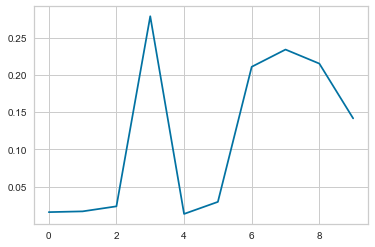

In [15]:
max_abs_for_each_lv_dimension_weight = find_absolute_largest_weights(weights=mean_weithts,
                                                                     num_out_units=mean_weithts.shape[1]
                                                                    )
plt.plot(max_abs_for_each_lv_dimension_weight)

## Get the output dimensions where weights are significant

[3 6 7 8 9]


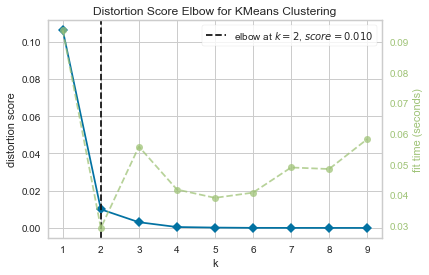

In [16]:
file_name = exp_config.ANALYSIS_PATH + "elbow_curve_weights_encoder_final_epoch_{}.jpg".format(epochs_completed)
significant_dimensions, cluster_centers_lv = get_significant_dimensions(max_abs_for_each_lv_dimension_weight,
                                                    file_name=file_name)
print(significant_dimensions)
max_abs_for_each_lv_dimension_weight = np.squeeze(max_abs_for_each_lv_dimension_weight)

# Decoder parameters

In [17]:
decoder_keys = [k for  k in decoder_params]
print(decoder_keys)

['decoder/de_fc1/Matrix:0', 'decoder/de_fc1/bias:0', 'decoder/de_dc3/w:0', 'decoder/de_dc3/biases:0', 'decoder/de_dc4/w:0', 'decoder/de_dc4/biases:0']


## Decoder layer 1

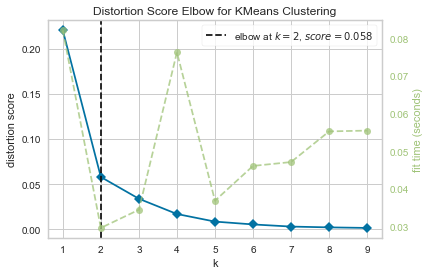

In [18]:
de_conv_weights_fc1 = decoder_params["decoder/de_fc1/Matrix:0"]
max_abs_for_each_out_dimension_weight = find_absolute_largest_weights(weights=de_conv_weights_fc1,
                                                                      num_out_units = exp_config.num_units[2]
                                                                     )
file_name = exp_config.ANALYSIS_PATH + "elbow_curve_weights_decoder_first_epoch_{}.jpg".format(epochs_completed)

significant_dimensions_decoder_fc1 = get_significant_dimensions(max_abs_for_each_out_dimension_weight,
                                                    file_name=file_name
                                                   )
max_abs_for_each_out_dimension_weight = np.squeeze(max_abs_for_each_out_dimension_weight)


In [19]:
de_conv_weights_dc4 = decoder_params["decoder/de_dc4/w:0"]
de_conv_bias_dc4 = decoder_params["decoder/de_dc4/biases:0"]

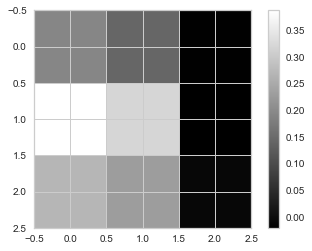

In [20]:
plt.imshow(np.squeeze(de_conv_weights_dc4[:, :, 0, 3]),cmap="gray")
plt.colorbar()

In [21]:
de_fc_weights = decoder_params["decoder/de_fc1/Matrix:0"]
de_fc_bias = decoder_params["decoder/de_fc1/bias:0"]

In [22]:
unused_features = []
for i in range(de_conv_weights_dc4.shape[3]):
    max_weight = np.max(np.squeeze(de_conv_weights_dc4[:, :, 0, i]))
    if max_weight <= 0.02:
        unused_features.append(i)
print(len(unused_features),
      unused_features)
    

20 [0, 2, 6, 11, 16, 18, 19, 21, 23, 25, 28, 29, 30, 34, 35, 38, 45, 52, 53, 55]


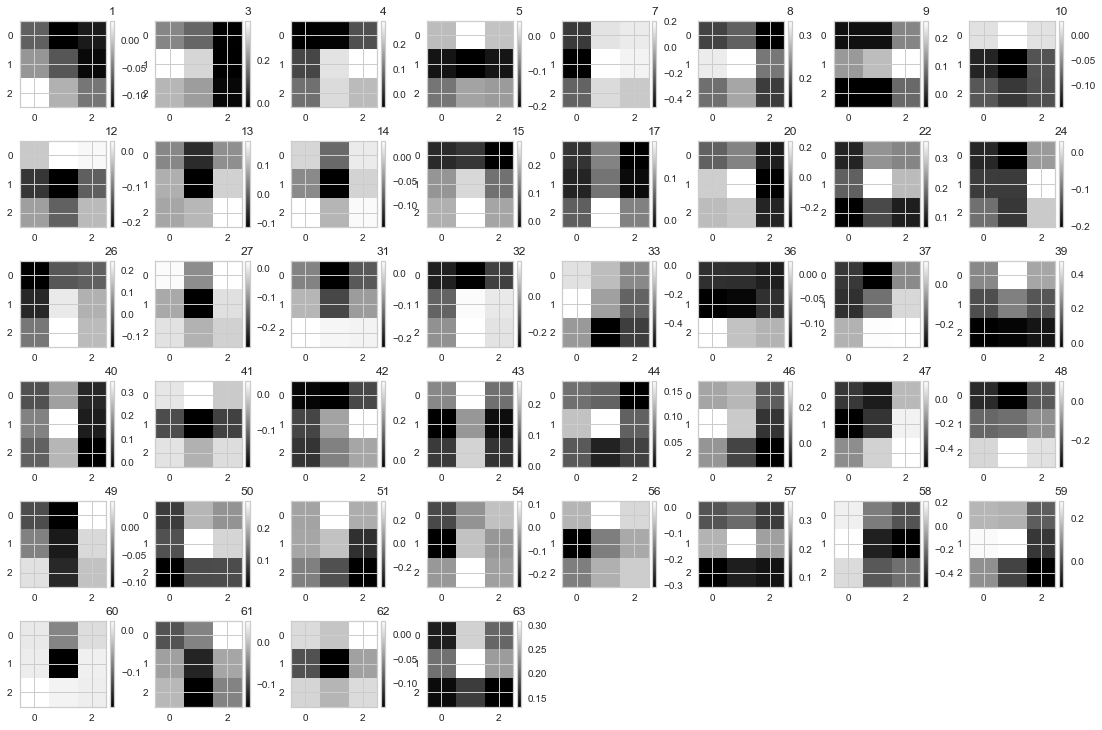

In [16]:
fig = plt.figure(figsize=(15, 10))
filter_num = 0
for i in range(de_conv_weights_dc4.shape[3]):
    if  i in unused_features:
        continue
    weights = np.squeeze(de_conv_weights_dc4[:, :, 0, i])
    ax = fig.add_subplot(6, 8, filter_num + 1)
    filter_num += 1
    plt.imshow(weights, cmap="gray")
    divider = make_axes_locatable(ax)
    cax1= divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    plt.title(str(i))
fig.tight_layout(pad=0.05)

# Load Validation images

In [17]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
train_val_iterator, val_images, val_labels, manual_annotation_np = load_images(exp_config,
                                                                    "val",
                                                                    manual_annotation_file)
unique_labels = train_val_iterator.get_unique_labels()
num_batches = val_images.shape[0] / exp_config.BATCH_SIZE
val_labels= np.argwhere(val_labels == 1)[:,1]

Warning /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/analysis/manual_annotation_epoch_9.0.csv path does not exist. Creating random prior with uniform distribution


# Get the Statistics of features at all levels

In [18]:
if recompute_feature_vectors:
    exp = Experiment(1, "VAE_MNIST", 128, exp_config, run_id)
    train_val_data_iterator = TrainValDataIterator.from_existing_split(exp.config.split_name,
                                                                       exp.config.DATASET_PATH,
                                                                       exp.config.BATCH_SIZE,
                                                                       manual_labels_config=exp.config.manual_labels_config,
                                                                       manual_annotation_file=None)

    model = None
    tf.reset_default_graph()
    train_df = None
    recompute_feature_vectors = False
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
            model = ClassifierModel(exp_config,
                                    sess,
                                    epoch=1,
                                    batch_size=BATCH_SIZE,
                                    z_dim=z_dim,
                                    dataset_name=DATASET_NAME,
                                    beta = exp_config.beta,
                                    num_units_in_layer=exp_config.num_units,
                                    log_dir=exp_config.LOG_PATH,
                                    checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                    result_dir=exp_config.PREDICTION_RESULTS_PATH
                                   )
            exp.model = model
            train_val_data_iterator.reset_counter("train")
            train_val_data_iterator.reset_counter("val")
            train_df = exp.encode_latent_vector_and_get_features(train_val_data_iterator,
                                                                 int(epochs_completed),
                                                                 "train",
                                                                 save_results=True)


In [19]:
# Load latent vectors for train data
n_3 = exp_config.num_units[exp_config.num_decoder_layer - 2]
n_2 = exp_config.num_units[exp_config.num_decoder_layer - 3]

z_stats = dict()
l3_stats = dict()

z_stats_given_label = dict()
l3_stats_given_label = dict()


filename  = get_encoded_csv_file(n_2, n_3, z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names, l3_col_names = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
train_latent_vectors_mean_by_label = dict()
train_latent_vectors_std_by_label = dict()
train_l3_vectors_mean_by_label = dict()
train_l3_vectors_std_by_label = dict()

for z_col_name in z_col_names:
    z_stats[z_col_name] = df[z_col_name].describe()
for l3_col_name in l3_col_names:
    l3_stats[l3_col_name] = df[l3_col_name].describe()

for label in unique_labels:
    z_stats_given_label[label] = dict()
    l3_stats_given_label[label] = dict()
    df_for_label = df[df["label"] == label]
    for z_col_name in z_col_names:
        z_stats_given_label[label][z_col_name] = df_for_label[z_col_name].describe()
    for l3_col_name in l3_col_names:
        l3_stats_given_label[label][l3_col_name] = df_for_label[l3_col_name].describe()
    train_latent_vectors_mean_by_label[label] = df_for_label[z_col_names].mean()
    train_latent_vectors_std_by_label[label] = df_for_label[z_col_names].std()
    

    
train_latent_vectors = df[z_col_names].values



#print("Latent vectors shape",train_latent_vectors.shape)

# for z_col_name in z_col_names:
#     z_min =z_stats[z_col_name]["min"]
#     z_max =z_stats[z_col_name]["max"]
#     z_std =z_stats[z_col_name]["std"]
#     print(f"feature_column_name ={z_col_name}\tmin={round(z_min,2)}\t\tmax={round(z_max,2)}\tstd={round(z_std,2)}")
    

# for l3_col_name in l3_col_names:
#     z_min =l3_stats[l3_col_name]["min"]
#     z_max =l3_stats[l3_col_name]["max"]
#     z_std =l3_stats[l3_col_name]["std"]
#     print(f"feature_column_name ={l3_col_name}\tmin={round(z_min,2)}\t\tmax={round(z_max,2)}\tstd={round(z_std,2)}")


## Encode and Decode validation images. Get the latent vectors and reconstructed images

In [26]:
model = None
tf.reset_default_graph()
val_latent_vectors_by_label = []
val_mu_by_label = []
val_sigma_by_label = []

reconstructed_images = []
images_by_label = []
val_decoder_features = defaultdict(list)
val_encoder_features = defaultdict(list)

reconstructed_images_from_l3 = []
train_l3_vectors_mean_by_label = np.zeros((len(unique_labels), len(l3_col_names)))

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=exp_config.BATCH_SIZE,
                                z_dim=z_dim,
                                dataset_name=exp_config.dataset_name,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        for d in range(len(unique_labels)):
            #mean l3  for training images
            df_for_label = df[df["label"] == d]
            train_l3_vectors_mean_by_label[d] = df_for_label[l3_col_names].mean().values
            #train_l3_vectors_std_by_label[d] = df_for_label[l3_col_names].std().values

            # validation images
            indices = np.argwhere(val_labels == d)
            images_by_label.append(val_images[indices])
            mus, sigmas, zs, dense2_ens, reshapeds, conv2_ens, conv1_ens = encode_and_get_features(model,
                                                                                                   np.squeeze(val_images[indices],
                                                                                                              axis=1),
                                                                                                   exp_config.BATCH_SIZE,
                                                                                                   exp_config.Z_DIM)
            val_encoder_features["dense_2"].append(dense2_ens)
            val_encoder_features["mu"].append(mus)
            val_encoder_features["sigma"].append(sigmas)
            val_latent_vectors_by_label.append(zs)
            
            recon_images,dense1_de, dense2_de, reshaped_de, deconv1_de = decode_and_get_features(model,
                                                                                                 val_latent_vectors_by_label[-1],
                                                                                                 exp_config.BATCH_SIZE)
            reconstructed_images.append( recon_images )
            recon_images_l3 = decode_l3(model, dense2_ens, exp_config.BATCH_SIZE)
            reconstructed_images_from_l3.append(recon_images_l3)
            
            val_decoder_features["dense_2"].append(dense2_de)
            val_decoder_features["dense_1"].append(dense1_de)
            val_decoder_features["deconv_1"].append(deconv1_de)
            
        reconstructed_images_from_mean_l3 = decode_l3(model, train_l3_vectors_mean_by_label, exp_config.BATCH_SIZE)

            

tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
Number of steps completed=9351
Number of epochs completed 10.0


In [27]:
reconstructed_images_from_mean_l3[0].shape

(28, 28, 1)

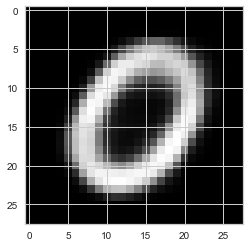

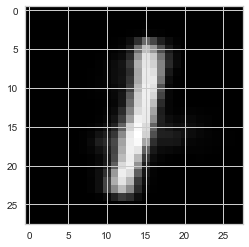

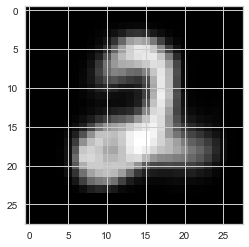

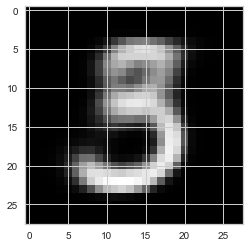

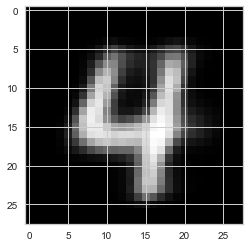

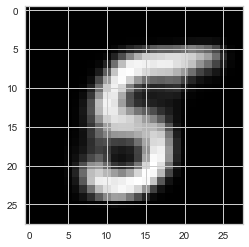

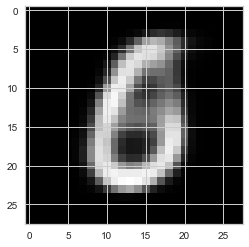

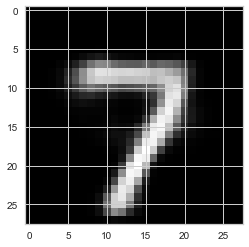

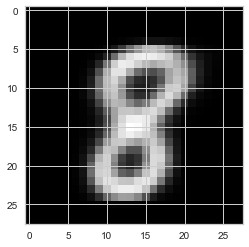

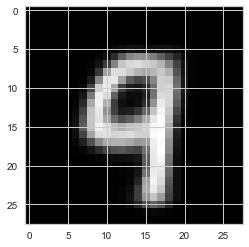

<Figure size 432x288 with 0 Axes>

In [28]:
display_images(reconstructed_images_from_mean_l3)

In [29]:
val_encoder_features["mu"][9][0]

array([-0.03539808,  0.00429916,  0.03408654, -0.49238163,  0.03114235,
        0.01388246, -1.64031863, -0.28251603, -0.21947134, -0.87078243])

In [30]:
def apply_activation(x, activation):
    if activation == "linear":
        return x
    elif activation == "lrelu":
        return np.where(x > 0, x, x * LEAK)

In [53]:
type(significant_dimensions)

numpy.ndarray

# Analyse final layer of encoder

In [108]:
def normalize(v):
    return v / np.linalg.norm(v)

def min_max_normalize(v):
    maximum = np.max(v)
    minimum = np.min(v)
    if maximum > 0:
        normalized = np.where(v > 0,v/maximum, v)
    if minimum > 0:
        normalized = np.where(normalized < 0,normalized/maximum, normalized)
    return normalized

        

In [109]:
min_max_normalize(f)

array([-0.81695843, -0.18528141, -0.08366436, -0.09025865, -0.73577666,
        0.40470526, -0.73489773,  0.40962372,  0.2802835 , -0.12615885,
        1.        , -0.00388365, -0.21144436, -0.40994224, -0.39718685,
       -0.15658467, -0.47360316, -0.04956366, -0.15433101, -0.37117204,
        0.04306286,  0.71171324, -0.0727986 , -0.19328581, -0.25164333,
       -0.3336623 , -0.21350864,  0.74613877, -0.25851753, -0.23888126,
        0.17243721, -0.0794446 ])

In [112]:
from collections.abc import Iterable
def plot_layer_weights_input_and_output(z_dim, w_fc4, bias_fc4, f, dimensions, lower_confidence, upper_confidence):
    if not isinstance(dimensions, Iterable):
        dimensions = [dimensions]
    for dim in dimensions:
        plt.figure(figsize=(15,10))
        plt.title(f"Output unit {dim}")

        plt.plot(min_max_normalize(w_fc4[:,dim] ))
        out = np.asarray(w_fc4[:,dim] * f)
        out_with_bias = np.append(out, bias_fc4[dim])
        output = apply_activation(np.sum(out_with_bias), activation)

        plt.plot(min_max_normalize(out_with_bias))
        #TODO plot output after activation also
        plt.plot([output] * 33)
        #plt.plot([np.sum(out_with_bias)/np.linalg.norm(out_with_bias)] * 33)
        
        ax = plt.gca()
        
        x = list(range(0, 30,1))
        print("Norm of out_with_bias",np.linalg.norm(out_with_bias))

        ax.fill_between(x,
                        lower_confidence/np.linalg.norm(out_with_bias),
                        upper_confidence/np.linalg.norm(out_with_bias),
                        color='b',
                        alpha=.1)
        print(f"Output unit {dim} value", output)
        
        plt.plot(min_max_normalize(f))
        plt.legend(["Weights", "Weights * Input","unit output", "Input"])
        
        #ax2 = ax.twinx()
        #ax2.plot(f)


Norm of out_with_bias 0.9551869172987222
Output unit 3 value -0.49238164211307245


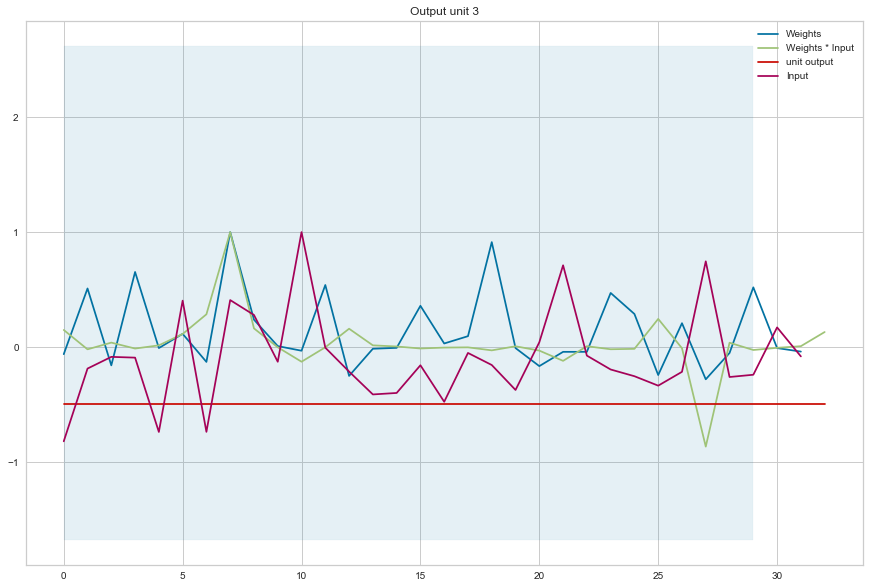

In [113]:
w_fc4 = encoder_params["encoder/en_fc4/Matrix:0"]
bias_fc4 = encoder_params["encoder/en_fc4/bias:0"]
activation = "linear"
plot_all_dimensions = False
val_sample_id = 0
digit = 9
# 32 dimensional encoding for digit `digit` validation sample id 0
f = val_encoder_features["dense_2"][digit][val_sample_id]
plot_layer_weights_input_and_output(z_dim, w_fc4, bias_fc4, f, significant_dimensions[0], -1.6, 2.5)


## Plot weights, input and output for mean feature for a given label

Output unit 3 value -0.6195582908808666


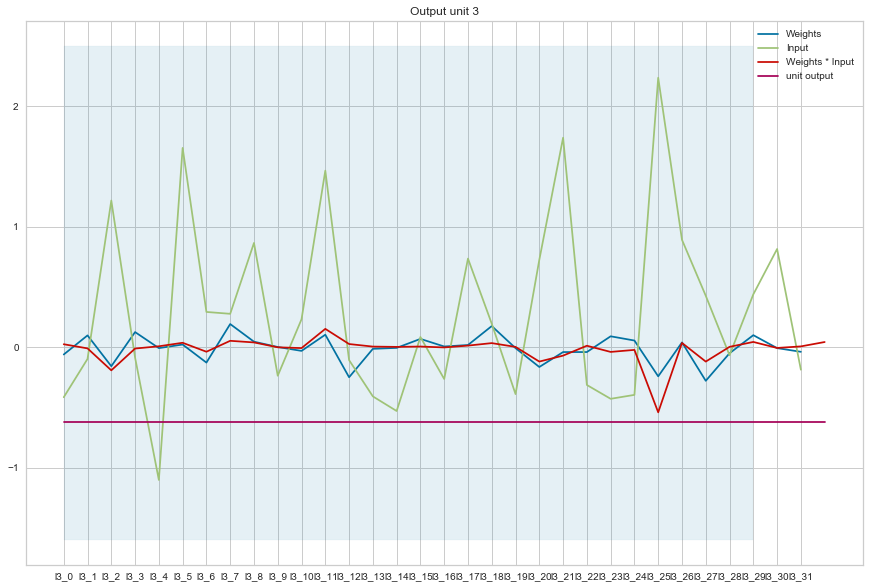

In [69]:
plot_all_dimensions = False
label = 9

# 32 dimensional encoding for label `label` 
df_for_label = df[df["label"] == label]
f = df_for_label[l3_col_names].mean()
plot_layer_weights_input_and_output(z_dim, w_fc4, bias_fc4, f, significant_dimensions[0], -1.6, 2.5)


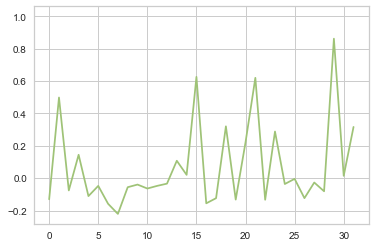

In [38]:
plt.figure()
for d in range(len(unique_labels)):
    num_images = len(images_by_label[d])
    features_en= val_encoder_features["dense_2"][d][0][0:num_images]
    features_en = features_en / np.max(features_en)
    features_de = val_decoder_features["dense_1"][d][0][0:num_images]
    plt.plot(features_en[0])
    plt.plot(features_de[0])
    break


In [39]:
num_images = len(images_by_label[0])
features_de = val_decoder_features["deconv_1"][d][0][0:num_images]

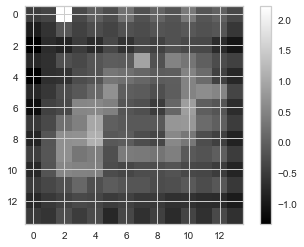

In [40]:
plt.imshow(np.squeeze(features_de[0, :, :, 3]),cmap="gray")
plt.colorbar()

(6272, 32)
Warning!  More than 2 clusters found. Need a better algorithm to find all significant cluster
[10 22 27 29 30]


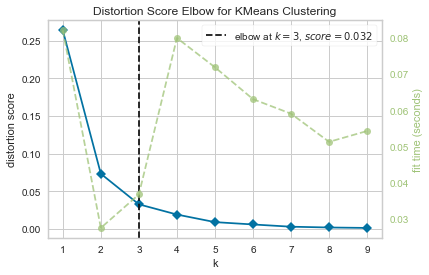

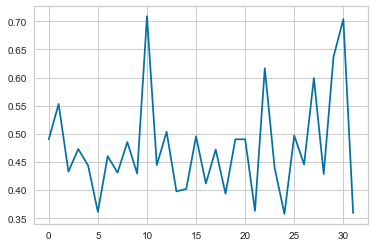

In [41]:
fc3_weights = encoder_params["encoder/en_fc3/Matrix:0"]
print(fc3_weights.shape)
max_abs_for_each_l3_dimension_weight = find_absolute_largest_weights(weights=fc3_weights,
                                                                     num_out_units=fc3_weights.shape[1]
                                                                    )
file_name = exp_config.ANALYSIS_PATH + "elbow_curve_weights_encoder_l3_epoch_{}.jpg".format(epochs_completed)
significant_dimensions_fc3, cluster_centers_l3 = get_significant_dimensions(max_abs_for_each_l3_dimension_weight,
                                                    file_name=file_name)
print(significant_dimensions_fc3)
max_abs_for_each_l3_dimension_weight = np.squeeze(max_abs_for_each_l3_dimension_weight)
plt.figure()
plt.plot(max_abs_for_each_l3_dimension_weight)


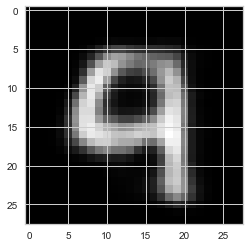

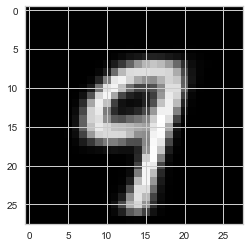

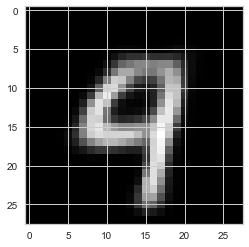

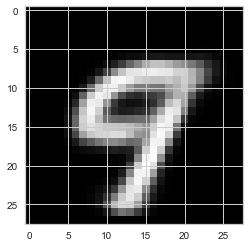

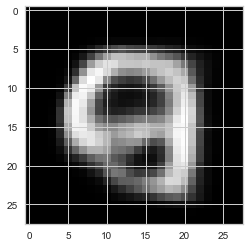

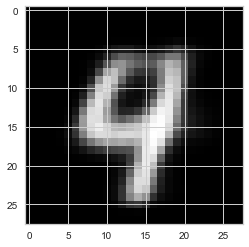

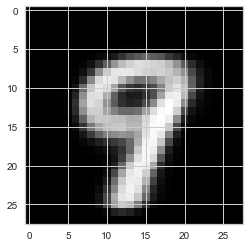

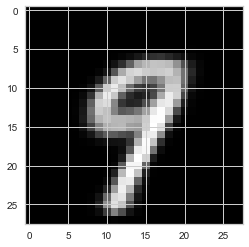

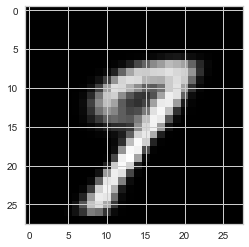

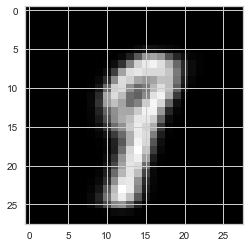

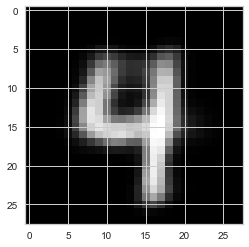

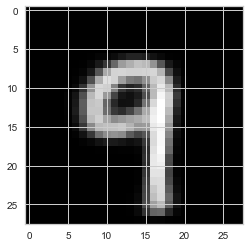

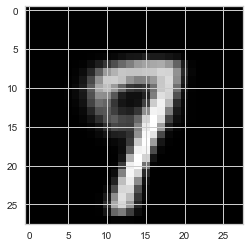

<Figure size 432x288 with 0 Axes>

In [61]:
display_images(reconstructed_images[9])

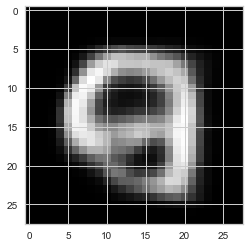

<Figure size 432x288 with 0 Axes>

In [62]:
display_images(reconstructed_images[9][4:5])

In [63]:
val_latent_vectors_by_label[d][0]

array([ 0.23123531, -0.54538149,  0.11319006, -0.44734994,  0.222139  ,
        0.84115124,  1.0166049 , -0.11057837, -0.70086038, -1.47925889])

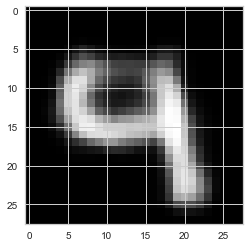

<Figure size 432x288 with 0 Axes>

In [64]:
display_images(reconstructed_images_from_l3[9][4:5])

In [65]:
val_latent_vectors_by_label[9][4]

array([ 0.39984843, -1.43920124, -1.90110815,  0.20451152, -0.83121479,
       -0.14968176, -1.10432863, -0.23502403, -0.82944894, -1.35574496])

In [66]:
val_encoder_features["dense_2"][9][4]

array([-0.73394752,  0.23031425, -0.36446065,  1.95150721, -0.31953165,
        0.80323416, -0.6212098 ,  3.46333027,  1.18439162, -0.34812224,
        5.50517368, -0.16756915, -0.40284038, -0.49111858, -0.29194599,
       -0.27249804, -0.40861264, -0.02678142,  0.98382902, -0.14738938,
        0.70934916,  3.32029033, -0.20760922, -0.23250437,  2.40034032,
       -0.45645186, -0.1942445 ,  3.52039599,  0.18570858, -0.01766399,
        1.32740915, -0.2518186 ])

In [67]:
cluster_centers_l3

array([[0.49190158],
       [0.65305454],
       [0.4088697 ]], dtype=float32)

In [68]:
len(val_mu_by_label)

0

In [69]:
val_sigma_by_label[9][0]

IndexError: list index out of range

In [70]:
plt.plot(val_mu_by_label[9][8])
plt.plot(val_latent_vectors_by_label[9][8])

IndexError: list index out of range

In [71]:
z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)

NameError: name 'mu' is not defined

In [72]:
plt.plot(sigma)

NameError: name 'sigma' is not defined

In [73]:
sigma = val_sigma_by_label[9][8]
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    normal_t = tf.random_normal((20,10), 0, 1,dtype=tf.float32)
    normal = sess.run(normal_t)

for i in range(normal.shape[0]):
    plt.plot(sigma * normal[i])
    
plt.figure()
for i in range(normal.shape[0]):
    plt.plot( normal[i])


IndexError: list index out of range

In [74]:
# for i  in range(latent_vectors.shape[0]):
#     plt.plot(latent_vectors[i])
#     plt.figure()

In [75]:
# print(reconstructed_images.shape)
# for i in range(reconstructed_images.shape[0]):
#     plt.imshow(np.squeeze(reconstructed_images[i]), cmap="gray")
#     plt.figure()

In [76]:
# def trace_dim(mu, num_trace_steps,  dim):    
#     z = np.zeros([num_trace_steps , z_dim])
#     for i in range(num_trace_steps):
#         z[i] = mu
#     z_min =  -5
#     z_max = 5
        
#     step = 1 / num_trace_steps
#     for i in range(num_trace_steps):
#         alpha_i = step * i
#         z[i, dim ] = alpha_i * z_min + (1 - alpha_i) * z_max
#     return z

In [77]:
len(val_encoder_features["dense_2"][1])

14

In [93]:
l3_dim = len(l3_col_names)

In [94]:
num_trace_steps = 36
tf.reset_default_graph()
reconstructed_deformed_images_l3 = []
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = ClassifierModel(
                            exp_config,
                            sess,
                            epoch=1,
                            batch_size=exp_config.BATCH_SIZE,
                            z_dim=z_dim,
                            dataset_name=exp_config.dataset_name,
                            beta = exp_config.beta,
                            num_units_in_layer=exp_config.num_units,
                            log_dir=exp_config.LOG_PATH,
                            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                            result_dir=exp_config.PREDICTION_RESULTS_PATH
                           )
    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    for d in range(len(unique_labels)):
        num_latent_vectors = 0
        total_latent_vectors =  l3_dim * num_trace_steps
        if total_latent_vectors < exp_config.BATCH_SIZE:
            total_latent_vectors = exp_config.BATCH_SIZE
        l3 = np.zeros([total_latent_vectors, l3_dim])
        for dimension in range(l3_dim):
            # TODO compute this for all images with each label
            l3_min = l3_stats[l3_col_names[dimension]]["min"]
            l3_max = l3_stats[l3_col_names[dimension]]["max"]
            traced_from_to = trace_dim(val_encoder_features["dense_2"][d][0], num_trace_steps, dimension, l3_dim, l3_min,l3_max)
            for i in range(num_trace_steps):
                l3[num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
        reconstructed_deformed_images_l3.append(decode_l3(model, l3, exp_config.BATCH_SIZE))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
Check point counter 9351

In [95]:
val_latent_vectors_by_label

[array([[ 2.31235310e-01, -5.45381486e-01,  1.13190062e-01,
         -4.47349936e-01,  2.22139001e-01,  8.41151237e-01,
          1.01660490e+00, -1.10578373e-01, -7.00860381e-01,
         -1.47925889e+00],
        [ 7.19478190e-01,  1.33874500e+00, -3.49637181e-01,
          5.04376471e-01, -1.26148093e+00, -1.45389283e+00,
          1.10384846e+00, -3.01535577e-01, -1.85085964e+00,
         -1.94995224e+00],
        [ 7.10784554e-01, -5.21236025e-02, -6.11714363e-01,
         -2.02715755e+00,  2.07981557e-01,  4.52211142e-01,
         -9.98351812e-01,  5.10938287e-01,  8.31888676e-01,
         -1.65517795e+00],
        [ 1.66431263e-01,  2.90060788e-01,  1.32939148e+00,
         -1.81238925e+00,  9.04007792e-01,  5.23202181e-01,
          1.42495096e-01, -1.55515671e+00, -7.33553231e-01,
         -1.57298887e+00],
        [ 1.09258652e+00,  1.28719902e+00, -1.16987377e-01,
         -7.01470375e-02,  4.58764762e-01, -1.91082895e+00,
          1.92542446e+00,  5.83333969e-01, -9.879461

In [97]:
num_trace_steps = 36
tf.reset_default_graph()
reconstructed_deformed_images = []
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = ClassifierModel(
                            exp_config,
                            sess,
                            epoch=1,
                            batch_size=exp_config.BATCH_SIZE,
                            z_dim=z_dim,
                            dataset_name=exp_config.dataset_name,
                            beta = exp_config.beta,
                            num_units_in_layer=exp_config.num_units,
                            log_dir=exp_config.LOG_PATH,
                            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                            result_dir=exp_config.PREDICTION_RESULTS_PATH
                           )
    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    for d in range(len(unique_labels)):
        num_latent_vectors = 0
        total_latent_vectors =  z_dim * num_trace_steps
        if total_latent_vectors < exp_config.BATCH_SIZE:
            total_latent_vectors = exp_config.BATCH_SIZE
        z = np.zeros([total_latent_vectors, z_dim])
        for dimension in range(z_dim):
            # TODO compute this for all images with each label
            z_min = z_stats[z_col_names[dimension]]["min"]
            z_max = z_stats[z_col_names[dimension]]["max"]

            traced_from_to = trace_dim(val_latent_vectors_by_label[d][0], num_trace_steps, dimension, z_dim, z_min, z_max)
            for i in range(num_trace_steps):
                z[num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
        reconstructed_deformed_images.append(decode(model, z, exp_config.BATCH_SIZE))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
Check point counter 9351

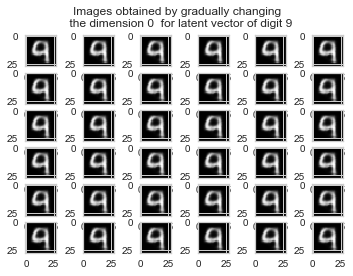

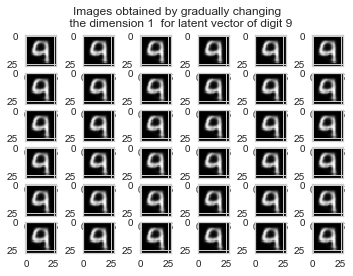

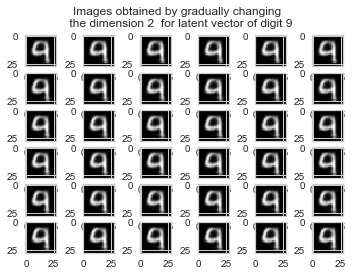

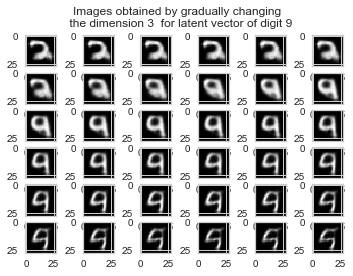

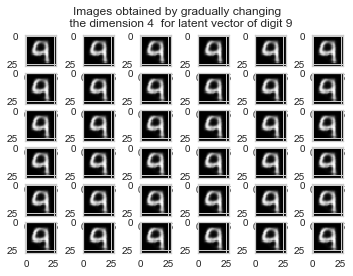

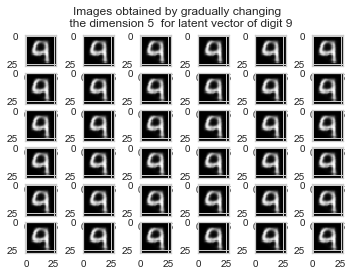

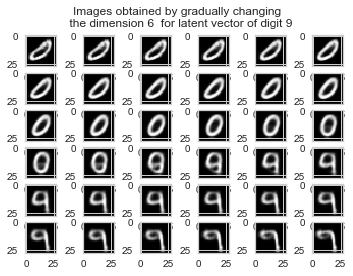

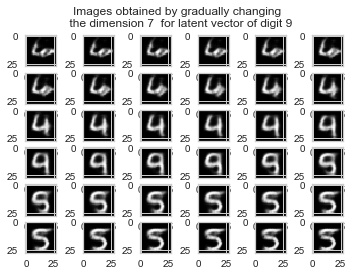

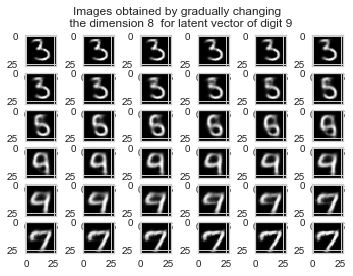

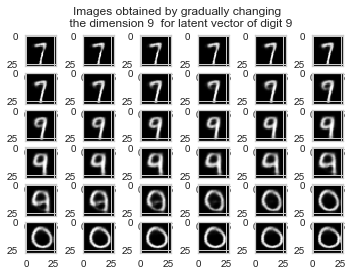

In [98]:
d = 9
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
for dim in range(10):
    fig = plt.figure()
    fig.suptitle(title_string.format(dim,d))
    for i in range(num_trace_steps):
        ax = fig.add_subplot(6, 6, i + 1)
        ax.imshow(np.squeeze(reconstructed_deformed_images[d][dim * num_trace_steps + i]), cmap="gray")
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


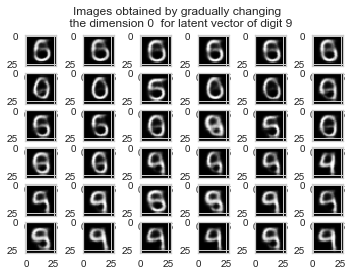

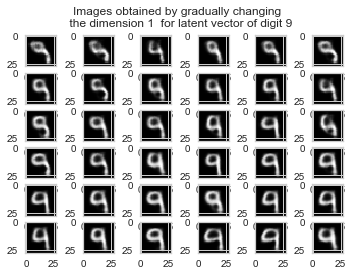

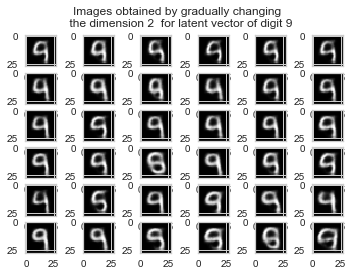

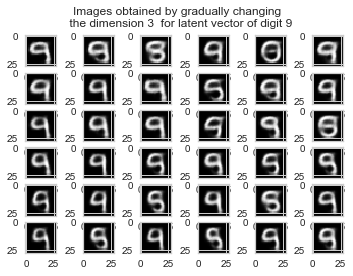

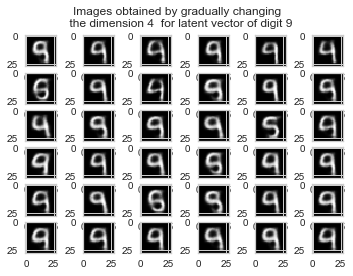

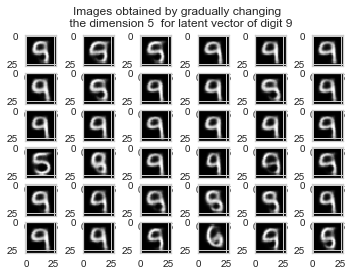

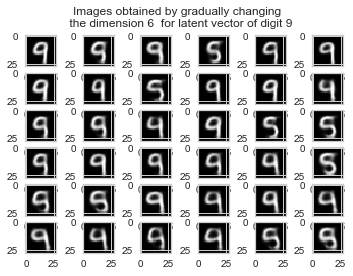

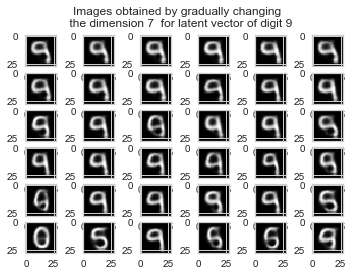

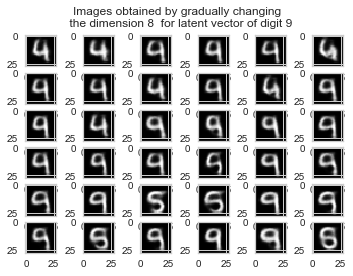

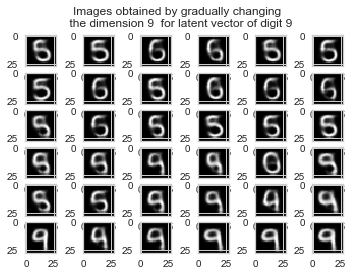

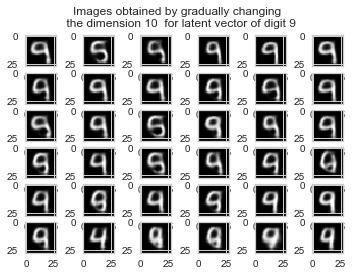

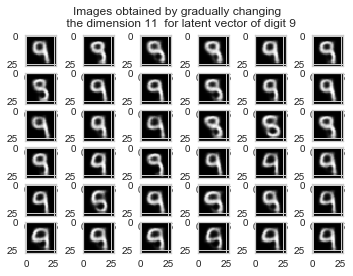

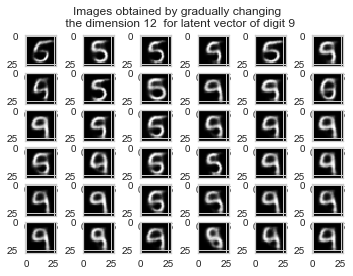

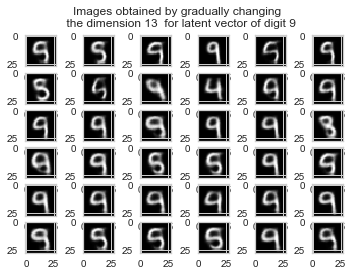

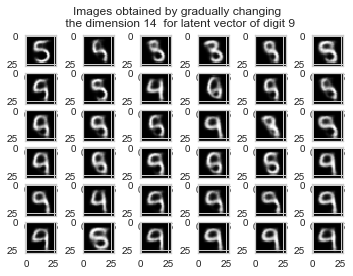

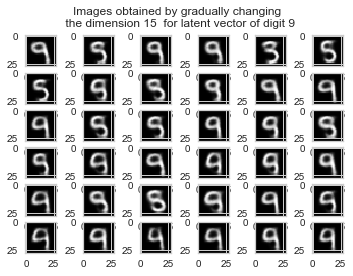

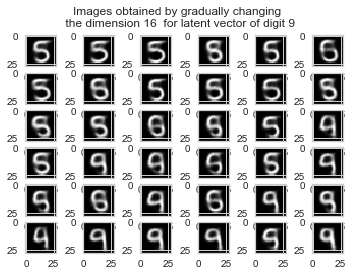

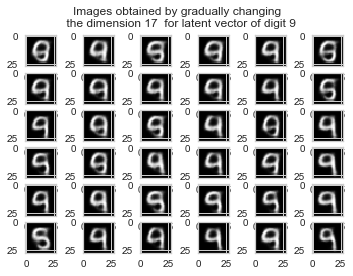

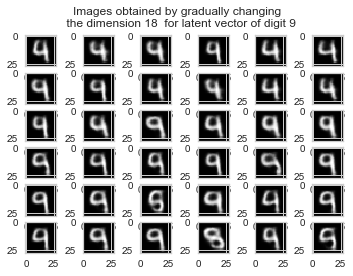

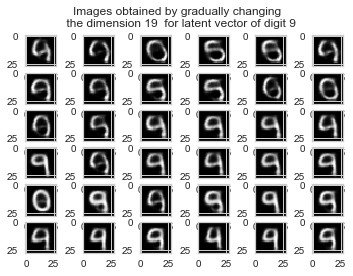

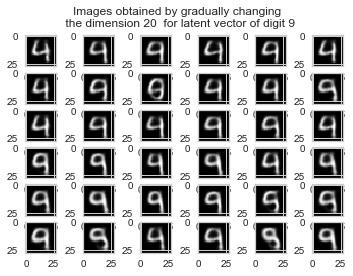

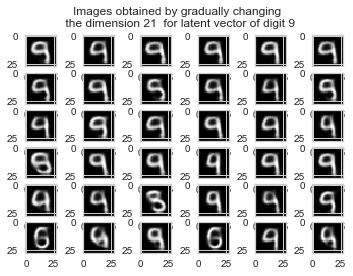

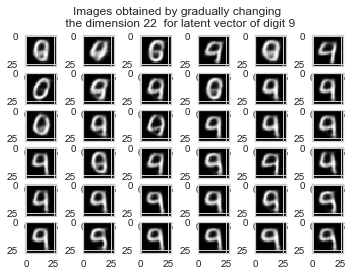

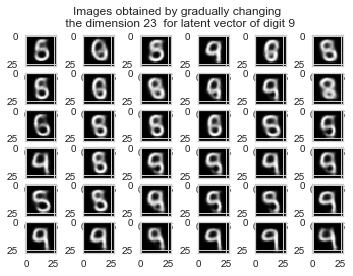

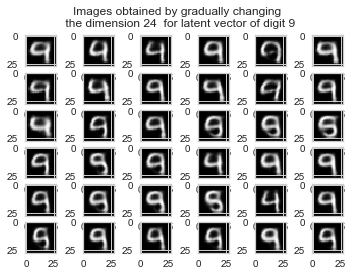

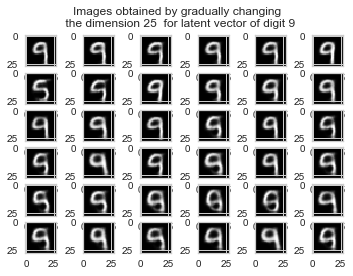

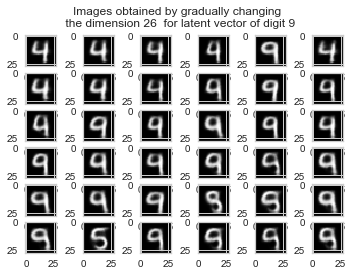

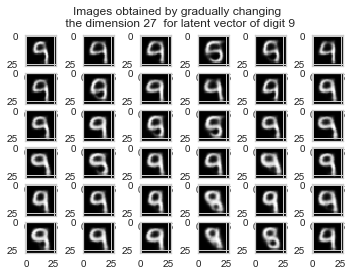

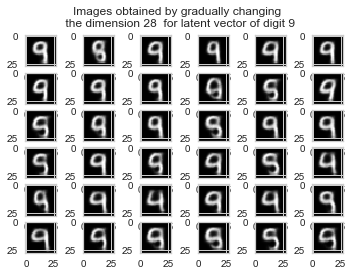

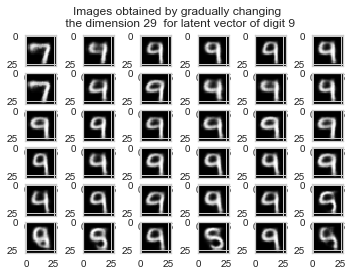

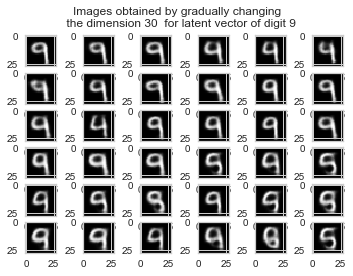

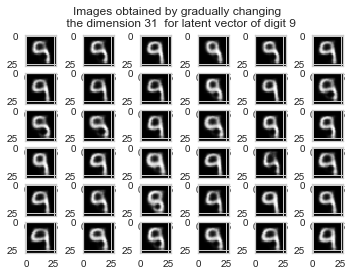

In [99]:
d = 9
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
for dim in range(l3_dim):
    fig = plt.figure()
    fig.suptitle(title_string.format(dim,d))
    for i in range(num_trace_steps):
        ax = fig.add_subplot(6, 6, i + 1)
        ax.imshow(np.squeeze(reconstructed_deformed_images_l3[d][dim * num_trace_steps + i]), cmap="gray")
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

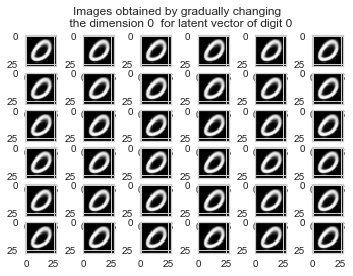

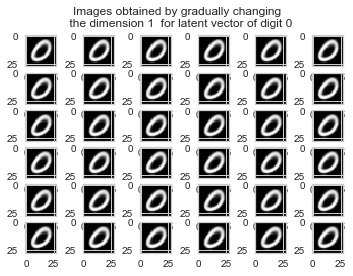

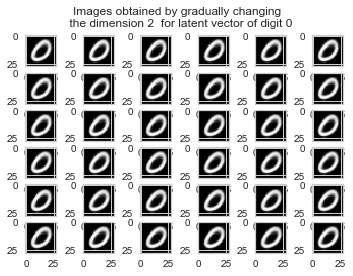

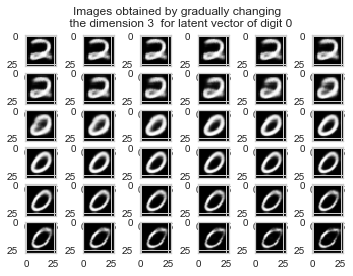

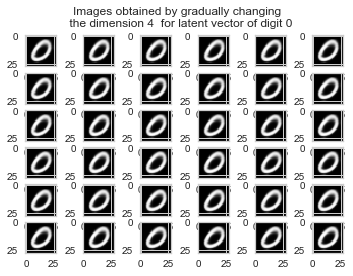

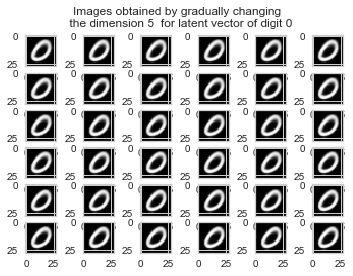

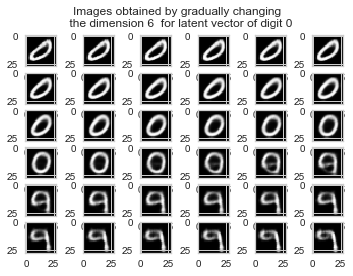

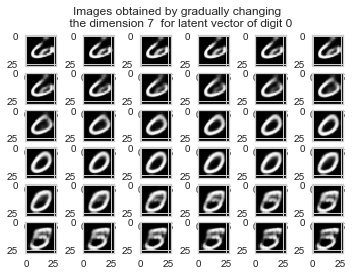

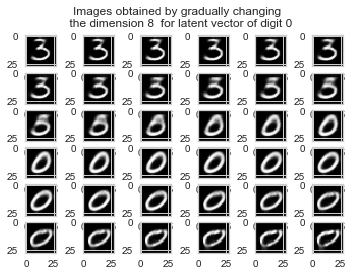

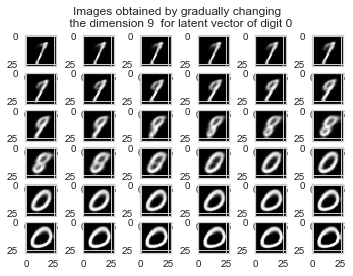

In [100]:
d = 0
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
for dim in range(10):
    fig = plt.figure()
    fig.suptitle(title_string.format(dim,d))
    for i in range(num_trace_steps):
        ax = fig.add_subplot(6, 6, i + 1)
        ax.imshow(np.squeeze(reconstructed_deformed_images[d][dim * num_trace_steps + i]), cmap="gray")
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

In [101]:
sensitive_dimensions = {
                        0:[3,6,7,8,9],
                        1:[1,2,3,5,7,8,9],
                        2:[1,2,3,5,7,8,9],
                        3:[1,2,3,5,7,8,9],
                        4:[1,2,3,5,7,8,9],
                        5:[1,2,3,5,7,8,9],
                        6:[1,2,3,5,7,8,9],
                        7:[1,2,3,5,7,8,9],
                        8:[1,2,3,5,7,8,9],
                        9:[3,6,7,8,9]
                       }

In [44]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
for d, _latent_vectors in enumerate(val_latent_vectors_by_label):
#     if d != 0:
#         continue
    fig = plt.figure(figsize=(15,10))
    mean_0 = np.mean(_latent_vectors,
                     axis = 0)

    for i in range(_latent_vectors.shape[0]):
#         if i % 4 == 0:
#             fig = plt.figure(figsize=(15,10))
        
        print(_latent_vectors.shape)
#         ax = fig.add_subplot(2, 2, i % 4 + 1)
#         plt.plot(_latent_vectors[i][sensitive_dimensions[d]])
#         #plt.xticks(list(range(len(sensitive_dimensions))),sensitive_dimensions[d])
#         iax = inset_axes(ax, width="50%",height=1,loc=1)

#         #plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
#         plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")
        

(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [45]:
train_latent_vectors.shape

(59840, 10)

In [46]:
mean_0.reshape([1,10])

array([[-0.20738049,  0.37913882,  0.04549619, -0.32991526,  0.3209753 ,
         0.68638858, -0.80012189, -0.42816207, -0.68222731,  0.4586589 ]])

In [48]:
val_latent_vectors_by_label.shape

(10,)

In [49]:
print(np.asarray(train_latent_vectors).shape )
print(np.asarray(val_latent_vectors).shape )

(59840, 10)


NameError: name 'val_latent_vectors' is not defined

In [41]:
val_latent_vectors = np.asarray(val_latent_vectors)
val_latent_vectors = np.reshape(val_latent_vectors,(128, exp_config.Z_DIM))
print(val_latent_vectors.shape)
# print(train_latent_vectors.shape)
# print(val_latent_vectors.shape)

NameError: name 'val_latent_vectors' is not defined

In [42]:
from sklearn.preprocessing import MinMaxScaler

#reconstructed_image_for_means = plot_mean_latentvector(val_latent_vectors, [0, 9])
reconstructed_image_for_means = plot_features(exp_config, features, digits, sensitive_dimensions,  True)
scaler = MinMaxScaler()
scaler.fit(train_latent_vectors)
scaler.transform(val_latent_vectors)

#plot_mean_latentvector(latent_vectors, 0, new_fig=False)

NameError: name 'features' is not defined

In [ ]:
reconstructed_image_for_means

In [ ]:
for reconstructed_image_for_mean in reconstructed_image_for_means:
    plt.figure()
    plt.imshow(np.squeeze(reconstructed_image_for_mean),cmap="gray")

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
for d, _latent_vectors in enumerate(latent_vectors):
    if d != 9:
        continue
    fig = plt.figure(figsize=(15,10))

    for i in range(_latent_vectors.shape[0]):
#         if i % 4 == 0:
#             fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(2, 2, i % 4 + 1)
        plt.plot(_latent_vectors[i][sensitive_dimensions[d]])
        #plt.xticks(list(range(len(sensitive_dimensions))),sensitive_dimensions[d])
        iax = inset_axes(ax, width="50%",height=1,loc=1)

        #plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
        plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")
        
        
        

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
for d, _latent_vectors in enumerate(latent_vectors):
    if d != 9:
        continue
    fig = plt.figure(figsize=(15,10))

    for i in range(_latent_vectors.shape[0]):
#         if i % 4 == 0:
#             fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(2, 2, i % 4 + 1)
        plt.plot(_latent_vectors[i][sensitive_dimensions[d]])
        #plt.xticks(list(range(len(sensitive_dimensions))),sensitive_dimensions[d])
        iax = inset_axes(ax, width="50%",height=1,loc=1)

        #plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
        plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")
        
        
        

In [ ]:
fig = plt.figure(figsize=(15,10))
d1 = 0
d2 = 9
l1 = np.mean(latent_vectors[d1], axis=0)
print(l1.shape)
l2 = np.mean(latent_vectors[d2], axis=0)
print(l2.shape)
ax = fig.add_subplot(2, 2, i % 4 + 1)
plt.plot(l1[sensitive_dimensions[d1]])
plt.plot(l2[sensitive_dimensions[d2]])
plt.legend([str(d1),str(d2)])

#plt.xticks(list(range(len(sensitive_dimensions))),sensitive_dimensions[d])
#iax = inset_axes(ax, width="50%",height=1,loc=1)

#plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
#plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")


In [ ]:
latent_vectors.shape

In [ ]:
model = None
tf.reset_default_graph()
latent_vectors_1 = np.zeros((5,z_dim))
latent_vectors_1[0] = l1
latent_vectors_1[1] = l2

latent_vectors_1[2] = l2
latent_vectors_1[2][6] = l1[6]


latent_vectors_1[3] = l2
latent_vectors_1[3][9] = l1[9]

latent_vectors_1[4] = l2
latent_vectors_1[4][6] = l1[6]
latent_vectors_1[4][9] = l1[9]

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = ClassifierModel(exp_config,
                            sess,
                            epoch=1,
                            batch_size=BATCH_SIZE,
                            z_dim=z_dim,
                            dataset_name=DATASET_NAME,
                            beta = exp_config.beta,
                            num_units_in_layer=exp_config.num_units,
                            log_dir=exp_config.LOG_PATH,
                            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                            result_dir=exp_config.PREDICTION_RESULTS_PATH
                           )
    num_steps_completed = model.counter
    print("Number of steps completed={}".format(num_steps_completed))
    num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
    epochs_completed = num_steps_completed // num_batches
    print("Number of epochs completed {}".format(epochs_completed))
    reconstructed_images_1 = decode(model, latent_vectors_1, exp_config.BATCH_SIZE)

tf.reset_default_graph()


In [ ]:
display_images(reconstructed_images_1)

In [ ]:
fig = plt.figure()
for i in range(2):
    plt.plot(latent_vectors_1[i][sensitive_dimensions[d2]])

for i in range(2,latent_vectors_1.shape[0]):
    fig = plt.figure()
    plt.plot(latent_vectors_1[i][sensitive_dimensions[d2]])


In [ ]:
for i in range(2):
    print(latent_vectors_1[i][sensitive_dimensions[d2]])

for i in range(2,latent_vectors_1.shape[0]):
    print(latent_vectors_1[i][sensitive_dimensions[d2]])


In [ ]:
from collections import defaultdict
sensitive_dimensions_all_labels =[]
sensitive_dimensions = defaultdict(list)

for d in range(len(unique_labels)):
    _reconstructed_deformed_images = reconstructed_deformed_images[d]
    for dim in range(Z_DIM):
        distances = []
        for step_num in range(num_trace_steps):
            distances.append(np.linalg.norm(np.squeeze(reconstructed_images[d][0]) - np.squeeze(_reconstructed_deformed_images[num_trace_steps * dim + step_num]) ))
        max_distance = max(distances)
        #print("Dimension {} Senssitivity {}".format(dim,max_distance))

        if max_distance > 10:
            sensitive_dimensions[d].append(dim)
    #sensitive_dimensions_all_labels.append(sensitive_dimensions)
    

In [ ]:
sensitive_dimensions

In [ ]:
plt.imshow(np.squeeze(reconstructed_images[0][0] ),cmap="gray")

In [ ]:
_reconstructed_deformed_images = reconstructed_deformed_images[0]

In [ ]:
# sensitive_dimensions = defaultdict(list)
# d= 0
# _reconstructed_deformed_images = reconstructed_deformed_images[d]
# for dim in range(Z_DIM):
#     distances = []
#     for step_num in range(num_trace_steps):
#         deformed = np.squeeze(_reconstructed_deformed_images[num_trace_steps * dim + step_num])
#         plt.imshow(deformed,cmap="gray")
#         distance = np.linalg.norm(np.squeeze(reconstructed_images[d][0]) - deformed )
#         plt.title(f"{dim}_{num_trace_steps * dim + step_num}_{distance}")
#         plt.figure()
#         distances.append(distance)
#     max_distance = max(distances)
#     print("Dimension {} Senssitivity {}".format(dim,max_distance))

#     if max_distance > 10:
#         sensitive_dimensions[d].append(dim)

In [ ]:
def insert_zeros(r,s):
    zero_inserted = np.zeros((s + 1) * r.shape[0])
    for i in range(r.shape[0]):
        zero_inserted[(s + 1) * i] = r[i]
    return zero_inserted

In [ ]:
def deconv(a, k, stride):
    result_1 = np.zeros(tuple([stride * s for s in a.shape]))
    for  i  in range(a.shape[0]):
        ai_zero_inserted = insert_zeros(a[i], stride- 1)
        result_1[stride * i,:] = ai_zero_inserted
    return correlate2d(result_1, k)

# Find significant filters

In [ ]:
def plot_output(out, threshold, fig_title=None):
    out_sigmoid = 1/(1 + np.exp(-out ))

    fig = plt.figure(figsize=(10,10))
    ax =  fig.add_subplot(2,2,1)
    plt.imshow(out, cmap="gray")
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title("Out")

    thresholded = np.zeros_like(out)
    thresholded[out > threshold] = 1
    ax = fig.add_subplot(2,2,2)
    plt.imshow(thresholded, cmap="gray")
    cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title(f"Thresholded at {threshold}")

    ax = fig.add_subplot(2,2,3)
    plt.imshow(out_sigmoid, cmap="gray")
    cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title("Sigmoid Output")
    
    if fig_title is not None:
        fig.suptitle(fig_title)

In [ ]:
h = features_de[0][:,:,i].shape[0]
w = features_de[0][:,:,i].shape[1]
stride = 2
padding = 1
num_filters = de_conv_weights.shape[3]
threshold = 1

deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
out = deconvolved + de_conv_bias
#plot_output(out, 1)
out_sigmoid = 1/(1 + np.exp(-out ))

fig = plt.figure(figsize=(10,10))
ax =  fig.add_subplot(2,2,1)
plt.imshow(out, cmap="gray")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title("Out")

thresholded = np.zeros_like(out)
thresholded[out > threshold] = 1
ax = fig.add_subplot(2,2,2)
plt.imshow(thresholded, cmap="gray")
cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title(f"Thresholded at {threshold}")

ax = fig.add_subplot(2,2,3)
plt.imshow(out_sigmoid, cmap="gray")
cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title("Sigmoid Output")

# if fig_title is not None:
#     fig.suptitle(fig_title)

In [ ]:
plt.hist(np.ravel(out),bins=100)

In [ ]:
num_filters

# Plot individual featuremaps

In [ ]:

fig = plt.figure(figsize=(15,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.imshow(feature_maps[i],cmap="gray")
    plt.colorbar()

In [ ]:
num_significant_filters = 20

filter_correlations = np.zeros(num_filters)
for filter_num in range(num_filters):
    m = np.corrcoef(feature_maps[filter_num].flat, out.flat)
    filter_correlations[filter_num] = m[0,1]
    
index_array = np.argsort(filter_correlations)
significant_filters = index_array[(num_filters- num_significant_filters):]
insignificant_filters = index_array[:(num_filters- num_significant_filters)]
print(significant_filters)

In [ ]:
index_array

In [ ]:
deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    if i  in insignificant_filters:
        continue
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
out = deconvolved + de_conv_bias
plot_output(out,1,"Top "+str(num_significant_filters)+" filters")


deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    if i  in significant_filters:
        continue
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
plot_output(out,1,"Bottom "+str(num_filters - num_significant_filters)+" filters")

In [ ]:
plt.hist(np.ravel(out),bins=100)

In [ ]:
fg_indices = np.where(out > 0)
for x, y in zip(fg_indices[0], fg_indices[1]):
    print(out[x,y])

In [ ]:
a = np.asarray([[1,4,5,10],[2,1,5,23],[1,2,20,14]])
print(a)
print(np.where(a != 1 ))

In [ ]:
deconvolved + de_conv_bias

In [ ]:
h = features_de[0][:,:,i].shape[0]
w = features_de[0][:,:,i].shape[1]
stride = 2

In [ ]:
de_conv_bias

In [ ]:
plt.imshow(np.squeeze(reconstructed_images[0][0]), cmap="gray")
plt.colorbar()

In [ ]:
def deconv2d(w, biases, input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, name="deconv2d", stddev=0.02, with_w=False):
    print("outputshape", output_shape)
    print("stride",[1, d_h, d_w, 1])
    deconv = tf.nn.conv2d_transpose(input_,
                                    w,
                                    output_shape=output_shape,
                                    strides=[1, d_h, d_w, 1],
                                    padding="SAME"
                                   )
    deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
    return deconv

In [ ]:
#deconv1_de = features_de
deconv1_de=decoder_features["deconv_1"][d][0]

In [ ]:
out = tf.nn.sigmoid(deconv2d(de_conv_weights, de_conv_bias, deconv1_de, [64, 28, 28, 1], 3, 3, 2, 2, name='de_dc4'))

In [ ]:
deconv1_de.shape

In [ ]:
de_conv_weights.shape

In [ ]:
de_conv_bias.shape

In [ ]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    de_conv_weights_tensor = tf.placeholder(tf.float32,[3, 3, 1, 64],name="weights")
    deconv1_de_tensor = tf.placeholder(tf.float32,[64,14, 14, 64], name="input")
    de_conv_bias_tensor = tf.placeholder(tf.float32,[1,],name="bias")
    out = tf.nn.sigmoid(deconv2d(de_conv_weights_tensor,
                                 de_conv_bias_tensor,
                                 deconv1_de_tensor,
                                 [64, 28, 28, 1],
                                 3, 3, 2, 2, name='de_dc4'
                                )
                       )
    reconstructed = sess.run(out,feed_dict={de_conv_weights_tensor:de_conv_weights,
                                            de_conv_bias_tensor:de_conv_bias,
                                            deconv1_de_tensor:deconv1_de
                                           })

In [ ]:
deconv1_de.shape

In [ ]:
plt.imshow(np.squeeze(reconstructed[0,:,:,:]),cmap="gray")

In [ ]:
print([k for k  in decoder_params.keys()])

In [ ]:
decoder_fc1_weights = decoder_params['decoder/de_fc1/Matrix:0']
decoder_fc1_bias = decoder_params['decoder/de_fc1/bias:0']

In [ ]:
np.matmul(latent_vectors[0][0],decoder_fc1_weights) + decoder_fc1_bias

In [ ]:
decoder_features["dense_1"][0][0][0]

In [ ]:
decoder_fc1_bias

In [ ]:
import os
import pandas as pd
import numpy as np
# from numpy.linalg import norm

# import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

from clearn.utils.data_loader import load_images
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
from clearn.analysis.encode_decode import decode, encode, encode_and_get_features, decode_and_get_features,decode_layer1

from matplotlib import pyplot  as  plt
%matplotlib inline

N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 10
run_id = 3

ROOT_PATH = "/home/sunilv/concept_learning_data/"
exp_config = ExperimentConfig(ROOT_PATH,
                              4,
                              Z_DIM,
                              [N_1, N_2, N_3],
                              num_val_samples=128,
                              confidence_decay_factor=5,
                              num_cluster_config=None)

exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


exp_config.TRAINED_MODELS_PATH


In [ ]:
z = np.zeros([64,10])

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=BATCH_SIZE,
                                z_dim=Z_DIM,
                                dataset_name=DATASET_NAME,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        dense1_de = decode_layer1(model,z,64)
        #recon_images,dense1_de, dense2_de, reshaped_de, deconv1_de = decode_and_get_features(model, z, exp_config.BATCH_SIZE)
tf.reset_default_graph()
N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 10
run_id = 3

ROOT_PATH = "/home/sunilv/concept_learning_data/"
exp_config = ExperimentConfig(ROOT_PATH,
                              4,
                              Z_DIM,
                              [N_1, N_2, N_3],
                              num_val_samples=128,
                              confidence_decay_factor=5,
                              num_cluster_config=None)

exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [ ]:
digit = 9
dense_1_feat_9 = np.mean(decoder_features["dense_1"][digit][0][0:13],axis=0)
dense_1_feat_9.shape

digit = 0
dense_1_feat_1 = np.mean(decoder_features["dense_1"][digit][0][0:13],axis=0)
dense_1_feat_1.shape
plt.plot(dense_1_feat_1)
plt.plot(dense_1_feat_9)


In [ ]:
digit = 9
dense_1_feat_9 = np.mean(decoder_features["deconv_1"][digit][0][0:13],axis=2)
print(dense_1_feat_9.shape)

digit = 0
dense_1_feat_1 = np.mean(decoder_features["deconv_1"][digit][0][0:13],axis=2)
print(dense_1_feat_1.shape)
# plt.imhsow(dense_1_feat_1)
# plt.plot(dense_1_feat_9)


In [ ]:
digit = 9
dense_1_feat_9 = np.mean(decoder_features["deconv_1"][digit][0][0:13],axis=0)
print(dense_1_feat_9.shape)
plt.imshow(dense_1_feat_9[:,:,2], cmap="gray")

In [ ]:
digit = 0
dense_1_feat_0 = np.mean(decoder_features["deconv_1"][digit][0][0:13],axis=0)
print(dense_1_feat_0.shape)
plt.imshow(dense_1_feat_0[:,:,2], cmap="gray")

In [ ]:
digit = 0
dense_1_feat_0 = np.mean(reconstructed_images[digit][0][0:13],axis=0)
print(dense_1_feat_0.shape)
plt.imshow(dense_1_feat_0[:,:,2], cmap="gray")

In [ ]:
de_conv_weights = decoder_params["decoder/de_dc4/w:0"]
de_conv_bias = decoder_params["decoder/de_dc4/biases:0"]